In [1]:
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def frange(start,step,end):
    n=int(np.ceil((end-start)/step))+1
    return np.arange(n)*step+start

In [47]:
def stochmod(lz,lx,dz,dx,az,ax,nu,seed=False):
    ''' 
    Create stochastical field
    lx= model length
    lz= model depth
    dx= sampling interval in x direction
    dz= sampling interval in z direction 
    ax= correlation length in x direction
    az= correlation length in z direction
    nu= Hurst exponent
    example stochmod(100,100,0.1,0.1,2,10,0.5)
    '''

    if (lx >= lz):
      n = int(np.round(lx/float(dx)))
    else:
      n = int(np.round(lz/float(dz)))
    

    h=1 
    while n > (2**h):
      h+=1 
    
    n=int(2**np.ceil(np.log2(n)))
    n2=int(n/2)

    kxnyq = 1./(2.*dx)
    dkx = 2.*kxnyq/n
    kx = frange(0.,dkx,kxnyq)*2.*np.pi

    kznyq = 1./(2.*dz)
    dkz = 2.*kznyq/n
    kz = np.zeros(n)
    kz[0:n2+1] = frange(0.,dkz,kznyq)*2.*np.pi
    kz[n2+1:] = frange(-kznyq+dkz,dkz,-dkz)*2.*np.pi

    ax = np.round(ax/dx)
    az = np.round(az/dz)

    #calculate power spectrum for 1st and 3rd quadrant
    p = np.zeros((n,n2+1))
    for i in np.arange(n2+1):
       for j in np.arange(n):
          p[j,i]= (1+(kx[i]*ax)**2+(kz[j]*az)**2)**-(nu+1)

    p = np.sqrt(p)
    if seed:
        np.random.seed(seed)

    p = p * np.exp(-1j*(np.random.uniform(size=(n,n2+1))-0.5)*2.*np.pi);

    #there are 4 points (dc value and 3 other points) without imaginary parts
    p[0,0]=np.real(p[0,0])
    p[0,n2]=np.real(p[0,n2])
    p[n2,0]=np.real(p[n2,0])
    p[n2,n2]=np.real(p[n2,n2])

    #enforce symmetry along top and central horizonal axis by adding columns
    p = np.concatenate([p,np.zeros((n,n-len(kx)))],axis=1)
    p[0,n2+1:]=np.conj(p[0,1:n2])[::-1]
    p[n2,n2+1:]=np.conj(p[n2,1:n2])[::-1]

    #enforce symmetry along left and central vertical axis
    p[n2+1:,0]=np.flipud(np.conj(p[1:n2,0]))
    p[n2+1:,n2]=np.flipud(np.conj(p[1:n2,n2]))

    #enforce symmetries for 2nd and 4th quandrants
    p[1:n2,n2+1:]=np.flipud(np.fliplr(np.conj(p[n2+1:,1:n2])))
    p[n2+1:,n2+1:]=np.flipud(np.fliplr(np.conj(p[1:n2,1:n2])))

    s = np.real(np.fft.ifft2(p))
    s=s-np.mean(np.mean(s))
    s=s/np.max(np.max(s))
    s = s/ np.mean(np.std(s))
    s = s[0:int(np.round(lz/dz)+1),0:int(np.round(lx/dx)+1)]

    #Normalization - small grid (Jens):
    s=s-np.mean(np.mean(s))
    s=s/np.max(np.max(s))
    s = s/np.mean(np.std(s))

    return s


In [46]:
n=int(np.round(1./float(0.01)))
n=int(2**ceil(log2(n)))
n/2
#np.arange(n/2+1)

64.0

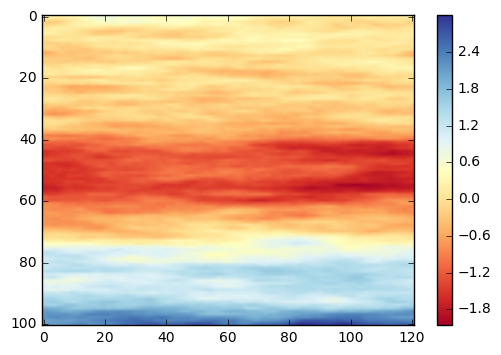

In [48]:
imshow(stochmod(1.,1.2,0.01,0.01,1,10,0.5),cmap='RdYlBu')
colorbar()

In [5]:
#check that the dimensions are defined vice versa!!!

In [6]:
import h5py
f = h5py.File('./stochmod/stoch_model.mat')
arrays = {}
for k, v in f.items():
    arrays[k] = np.array(v)


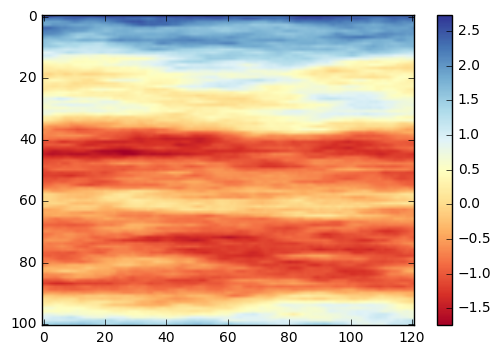

In [7]:
imshow(arrays[u'stoch_model'].T,cmap='RdYlBu')
colorbar()

## Pandas Test

In [8]:
hdf = pd.HDFStore('./stochmod/stochm.h5')
soilstoch = pd.DataFrame(stochmod(1.,1.2,0.01,0.01,1,10,0.5))
hdf.put('soils/idx',soilstoch,format='t')

/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-pac

In [9]:
#soilstoch
pd.read_hdf('./stochmod/stochm.h5', 'soils/idx')

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,1.979338,1.960119,1.947742,1.899218,1.913490,1.916668,1.905699,1.886279,1.863743,1.875786,...,2.154658,2.191447,2.172436,2.158903,2.162034,2.198756,2.264840,2.290833,2.285493,2.264751
1,2.236467,2.239908,2.263401,2.275945,2.278015,2.275814,2.267233,2.271307,2.278763,2.327748,...,2.000727,2.007936,2.063937,2.148641,2.236141,2.277882,2.298150,2.311218,2.326304,2.329261
2,2.350230,2.308895,2.272528,2.256365,2.283696,2.276691,2.292726,2.339668,2.334339,2.301995,...,1.999600,2.025746,2.058152,2.103495,2.089099,2.101199,2.111295,2.136170,2.180930,2.237439
3,2.287093,2.265078,2.285076,2.304130,2.342042,2.334116,2.302997,2.294111,2.240767,2.196051,...,2.005713,2.070470,2.117322,2.123635,2.139241,2.112243,2.126434,2.136836,2.126030,2.155443
4,2.065426,2.090484,2.120793,2.136683,2.128307,2.137099,2.159583,2.141082,2.140016,2.133817,...,1.872030,1.857164,1.830265,1.834152,1.910909,1.934700,1.918755,1.892954,1.852569,1.835648
5,1.664523,1.687989,1.739156,1.791002,1.825633,1.838659,1.855259,1.852358,1.869474,1.852231,...,1.601164,1.585338,1.586392,1.568798,1.594843,1.597684,1.543915,1.552905,1.578678,1.607376
6,1.498419,1.532127,1.535185,1.513182,1.522180,1.515386,1.497891,1.500351,1.498834,1.552801,...,1.499868,1.488196,1.480928,1.474573,1.501874,1.509601,1.521888,1.519964,1.535949,1.538653
7,1.347136,1.322043,1.285161,1.255993,1.239862,1.224468,1.218351,1.219263,1.209021,1.221932,...,1.414157,1.389769,1.378481,1.394005,1.421663,1.435906,1.421669,1.417100,1.431130,1.449846
8,1.327290,1.308942,1.307648,1.269476,1.220490,1.189200,1.183965,1.198975,1.212622,1.245375,...,1.046891,1.083206,1.120373,1.157419,1.150850,1.139384,1.112076,1.110823,1.099063,1.126992
9,1.163961,1.162056,1.167959,1.167617,1.128623,1.102243,1.110864,1.125739,1.147618,1.157199,...,1.059444,1.035262,1.047121,1.079023,1.088864,1.103738,1.111203,1.135296,1.134433,1.118007


/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-pac

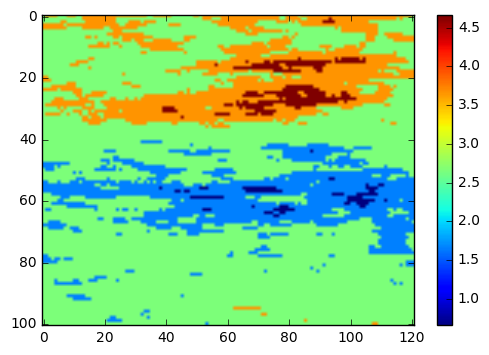

In [10]:
smx=stochmod(1.,1.2,0.01,0.01,2,10,0.25)
imshow(smx.astype(int)-smx.min().min())
colorbar()

In [17]:
soilstoch.max().max()

1.7599962796831246

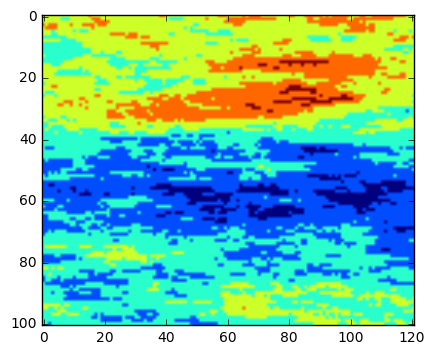

In [14]:
(smx-smx.min().min()).astype(int)

In [26]:
smx=stochmod(1.2,1.,0.01,0.01,2,10,0.25)
with h5py.File('stoch_model10.h5', 'w') as f:
    dset = f.create_dataset("data", np.shape(smx.T)+(10,), dtype='i')
    dset[:,:,0] =  (smx-smx.min().min()).astype(int).T
    



/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/cojack/anaconda/lib/python3.5/site-pac

In [23]:
np.shape(smx)+(10,)

(101, 121, 10)